# Brands and products emotion dataset analisys 

In [270]:
#Importing important stuff
import nltk
import sklearn
import string
import re
import keras

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
#weee

In [271]:
#Loading in dataset
path_to_dataset = 'tweets.csv'
df = pd.read_csv(path_to_dataset, dtype=str)

In [272]:
df = df.rename(columns = {'emotion_in_tweet_is_directed_at':'products', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotions'})
df = df.set_index('index')

## Entry analisys

In [273]:
df.describe()

,tweet_text,products,emotions
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [274]:
df.head()

,tweet_text,products,emotions
index,,,
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


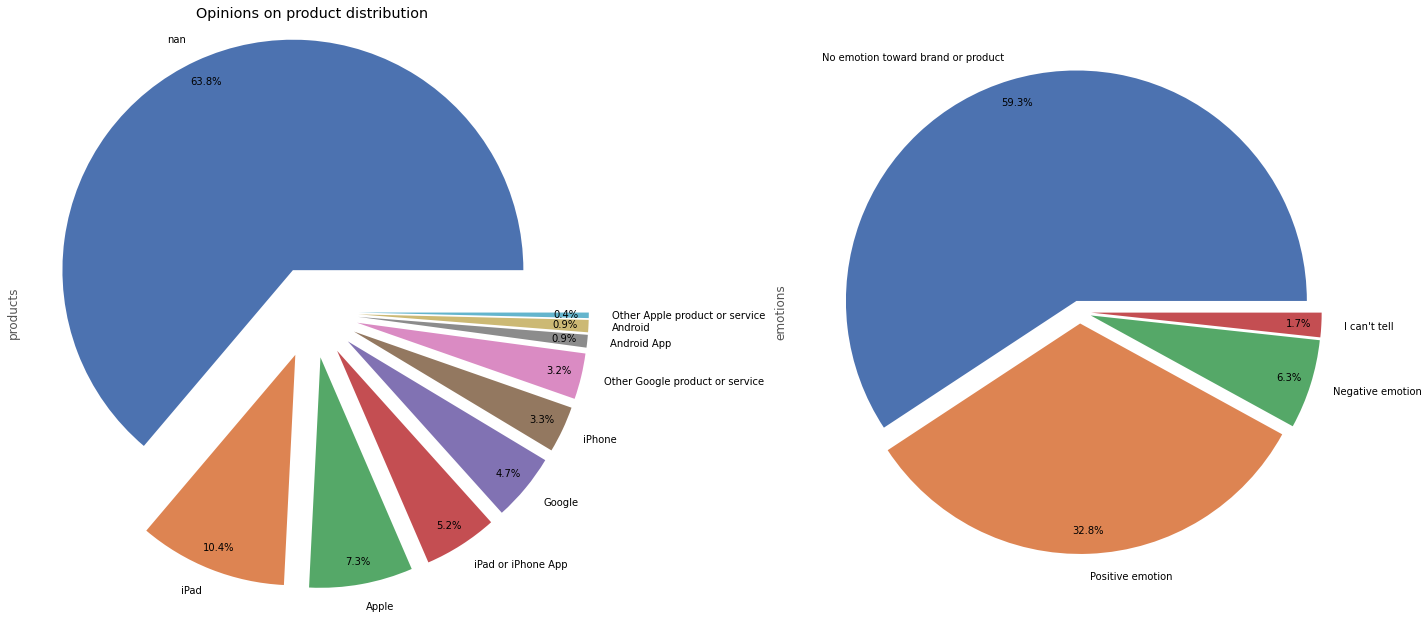

In [275]:
products= df['products'].value_counts(dropna=False)
emotions=df['emotions'].value_counts(dropna=False)

distance = [0.2 for i in products]
labels = ['' for i in products]
colors = sns.color_palette('deep')

fig = plt.figure(figsize=(20,20))


fig.add_subplot(1,2,1)
ax = products.plot.pie(autopct='%1.1f%%', colors=colors, explode=distance, grid=False, pctdistance=0.90)
ax.set_title('Opinions on product distribution')

fig.add_subplot(1,2,2)
ax3 = df.emotions.value_counts(dropna=False)
distanceEmotions = [0.05 for i in ax3]
ax3.plot.pie(autopct='%1.1f%%', colors=colors, explode=distanceEmotions, grid=False, pctdistance=0.90)

fig.tight_layout()
plt.show()

As we can see, there is a lot of unassigned data, in both emotions and products columns. Because of that, we have unbalanced data, especially in 'Emotions' column – meaning there is an overwhelming amount of one feature in the dataset. 
If we would try to train a neural network on unbalanced data, we would overfit the network to classify most of the occurrences of the dominant feature.
 
What can we do to prevent such a thing? We can balance our data set. Basically, in this case we will try to match the size of the smallest feature in our data set. In the case of the 'Emotions' column that would mean to fit the size of 'Positive emotion' to the size of 'Negative emotion'. Quick math: 6.3% of 9093 is 572, which means that we should only use 572 examples from 'Positive Emotions' (we don't want to use 'No Emotions' because this won't help us with determinating if a tweet is positive or negative, neither 'Can't tell' column will help us with this task).

In [276]:
throw_away = df.loc[df.emotions.isin(["No emotion toward brand or product","I can't tell"])].index
df.drop(throw_away, inplace=True)

emotions_count = df.emotions.value_counts()
procentage = int(100 - (emotions_count[1]*100)/emotions_count[0]) * 0.01

positive_emotion  = df.loc[df['emotions'] == "Positive emotion"]
index_possitive = positive_emotion.sample(frac=procentage).index
df.drop(index_possitive, inplace=True)

In [277]:
df.describe()

,tweet_text,products,emotions
count,1166,1058,1166
unique,1165,9,2
top,I just noticed DST is coming this weekend. How...,iPad,Positive emotion
freq,2,275,596


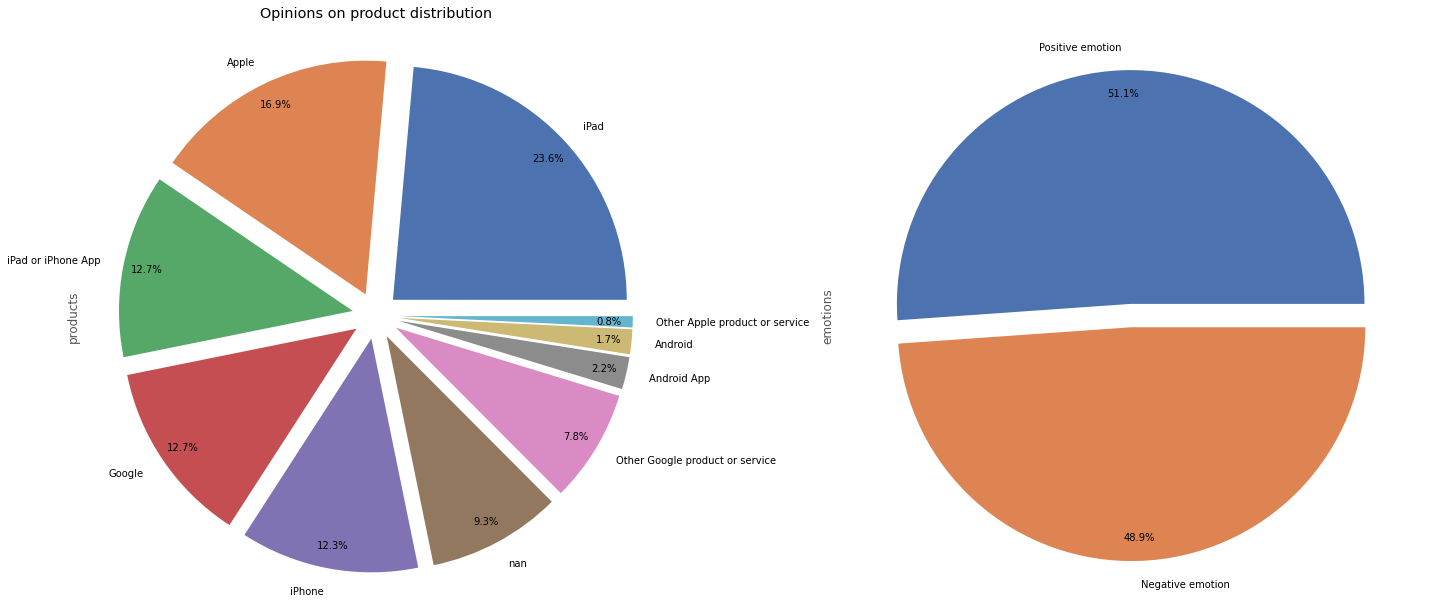

In [278]:
products=df['products'].value_counts(dropna=False)
emotions=df['emotions'].value_counts(dropna=False)

distance = [0.1 for i in products]
labels = ['' for i in products]
colors = sns.color_palette('deep')

fig = plt.figure(figsize=(20,20))
fig.add_subplot(1,2,1)
ax = products.plot.pie(autopct='%1.1f%%', colors=colors, explode=distance, grid=False, pctdistance=0.90)
ax.set_title('Opinions on product distribution')

fig.add_subplot(1,2,2)
ax3 = df.emotions.value_counts(dropna=False)
distanceEmotions = [0.05 for i in ax3]
ax3.plot.pie(autopct='%1.1f%%', colors=colors, explode=distanceEmotions, grid=False, pctdistance=0.90)

fig.tight_layout()
plt.show()

## Text normalization

In [279]:
dfRaw = df.copy()
df.tweet_text = df.tweet_text.astype(str)

In [280]:
#changing formating of the text to lower letters
df.tweet_text = df.tweet_text.apply(lambda x: x.lower())

In [281]:
def cleanseText(textColumn):
    #cleansing text from anomalies like links, nicknames etc...
    textColumn = textColumn.apply(lambda x: re.sub(".iphone.|.ipad.|.google.|.app.","",x))
    textColumn = textColumn.apply(lambda x: re.sub("@\w+","",x))
    textColumn = textColumn.apply(lambda x: re.sub(r'\w*\d+\w*','',x))
    textColumn = textColumn.apply(lambda x: re.sub(r'{link}','',x))
    textColumn = textColumn.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    textColumn = textColumn.apply(lambda x: x.strip())
    textColumn = textColumn.apply(lambda x: re.sub("sxsw","",x))

    return textColumn


stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words.remove('not')
stop_words.remove('nor')
stop_words.remove('no')


df["tweet_text"] = cleanseText(df.tweet_text)

#removing stopwords like em, or...
df["tweet_text"] = df["tweet_text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
df["One_Hot_Vector"] = df["emotions"].apply(lambda x: 1 if x == "Positive emotion" else 0)

In [282]:
df

,tweet_text,products,emotions,One_Hot_Vector
index,,,,
0,hrs tweeting riseaustin dead need upgrade plug...,iPhone,Negative emotion,0
1,know awesomeiphonethat youll likelyeciate desi...,iPad or iPhone App,Positive emotion,1
3,hope years festival isnt crashy yearsapp,iPad or iPhone App,Negative emotion,0
4,great stuff fri marissa mayer tim oreilly tech...,Google,Positive emotion,1
17,noticed dst coming weekend manyusers hour late...,iPhone,Negative emotion,0
...,...,...,...,...
9043,hey anyone signing group texting groupme got n...,NaN,Negative emotion,0
9045,favorite thanks coming getting anagain,iPhone,Positive emotion,1
9061,realize im still padless gave away case bmm ne...,iPad,Positive emotion,1


## Text vectorization

In [283]:
from sklearn.feature_extraction.text import CountVectorizer

#vectorizing texts of tweets

vectorizer = CountVectorizer(lowercase=False)

sentences, oneHot = df.tweet_text.to_numpy(), df.One_Hot_Vector.to_numpy()

vectorizer.fit(sentences)
sentences = vectorizer.transform(sentences).toarray()

#splitting data for trainig (80%) and testing (20%)
procent = int(oneHot.shape[0] * .8)

X_train, y_train = sentences[:procent], oneHot[:procent]
X_test, y_test = sentences[procent:], oneHot[procent:]

## Creating linear model for comparison

In [292]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()

classifier.fit(X_train, y_train)
Linearscore = classifier.score(X_test, y_test)

print(f'Accuracy {Linearscore:.2f}')

Accuracy 0.77


## Creating deep neural network

In [285]:
from keras.models import Sequential

inputSize = X_train.shape[1]
model = Sequential()

model.add(keras.layers.Dense(10, input_dim=inputSize, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [286]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                36170     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 36,181
Trainable params: 36,181
Non-trainable params: 0
_________________________________________________________________


In [287]:
history = model.fit(X_train, y_train,epochs=100,verbose=True,validation_data=(X_test, y_test),batch_size=10)


In [288]:
keras.backend.clear_session()

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7778


In [289]:
history.history['acc']

[0.6083691120147705,
 0.8487124443054199,
 0.9141631126403809,
 0.942060112953186,
 0.9603004455566406,
 0.9742489457130432,
 0.9806867241859436,
 0.9860514998435974,
 0.9892703890800476,
 0.9903433322906494,
 0.9924892783164978,
 0.9946351647377014,
 0.9924892783164978,
 0.995708167552948,
 0.995708167552948,
 0.995708167552948,
 0.995708167552948,
 0.995708167552948,
 0.9946351647377014,
 0.995708167552948,
 0.9967811107635498,
 0.9967811107635498,
 0.9967811107635498,
 0.9967811107635498,
 0.9967811107635498,
 0.9967811107635498,
 0.9978540539741516,
 0.9978540539741516,
 0.9989270567893982,
 0.9978540539741516,
 0.9967811107635498,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 0.9989270567893982,
 1.0,
 1.0,
 0.9989270567893982,
 1.0,
 1

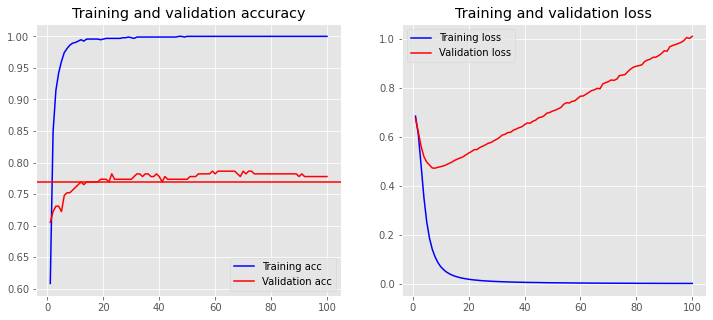

In [301]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.axhline(y=Linearscore, color='r', linestyle='-')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


As we can see, the validation and training data is overfitting our model. It is the case because our training data wasn't great in the first place. It was scarse (most of training data contains at least couple thousand cases, our contained only 1066). cleansing of the data wasn't as robust as it could be. Thus we couldn't expect much from neural network. Linear model could do just perfectly.